<a href="https://colab.research.google.com/github/c-core-labs/notebooks/blob/master/notebooks/download-from-aws-s3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download from AWS S3
Examples of how to download files from S3 buckets with Python

## Install dependencies

In [21]:
!pip install boto3
!pip install backoff
!pip install matplotlib
!pip install rasterio

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/01/9d/416ca5d453c776fa8db35d1bbfed65809e06ae021154f86c45d34f44ce39/matplotlib-3.2.1-cp38-cp38-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/64/8b/a70681c9a471f8187fed80d0aa9c9bb55ec3bf9daa50bd1cdc0c73d4910c/kiwisolver-1.1.0-cp38-cp38-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Download functions

In [31]:
import boto3
import os
import logging
import backoff
from pathlib import Path
from urllib.parse import urlparse

from typing import Optional


logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)


# Enter your AWS Access Key ID and Secret Access Key here:
aws_access_key_id = ''
aws_secret_access_key = ''


# Connection errors sometimes occur at random. This backoff decorator waits a few seconds and retries up to `max_tries`
@backoff.on_exception(
    backoff.expo, ConnectionError, jitter=backoff.full_jitter, max_tries=5
)
def download_file(bucket, key, destination_path, client=s3_client):
    """
    Download a single file
    """
    client.download_file(bucket, key, destination_path, {"RequestPayer": "requester"})
    
    return Path(destination_path)


def download_directory(bucket, prefix, local, client=s3_client, dry_run=False):
    """
    Recursively download an AWS S3 path

    params:
    - bucket: s3 bucket with target contents
    - prefix: pattern to match in s3
    - local: local path to folder in which to place files  
    - client: initialized s3 client object

    Adapted from https://stackoverflow.com/a/56267603/583830
    """
    keys = []
    dirs = []
    destination_paths = []
    next_token = ""
    base_kwargs = {"Bucket": bucket, "Prefix": prefix, "RequestPayer": "requester"}
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != "":
            kwargs.update({"ContinuationToken": next_token})
        results = client.list_objects_v2(**kwargs)
        contents = results.get("Contents")
        if contents:
            for i in contents:
                k = i.get("Key")
                if k[-1] != "/":
                    keys.append(k)
                else:
                    dirs.append(k)
            next_token = results.get("NextContinuationToken")
        else:
            log.warning(f"No data found for s3://{bucket}/{prefix}")
            break
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            if not dry_run:
                os.makedirs(os.path.dirname(dest_pathname))
    if len(keys) == 0:
        log.warning(f"{prefix} has no data available")
    for k in keys:
        product_identifier = k.split("/", 6)[6]
        dest_pathname = os.path.join(local, product_identifier)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            if not dry_run:
                os.makedirs(os.path.dirname(dest_pathname))
        if not dry_run:
            try:
                log.info(f"Downloading file {dest_pathname}")
                destination_path = download_file(bucket, k, dest_pathname, client)
                destination_paths.append(destination_path)
            except ConnectionError:
                log.warning(f"ConnectionError when downloading {k}")
                
    return destination_paths


def download_uri(
    source_uri: str, 
    local_directory: str = './', 
    client: Optional[boto3.client] = None,
    aws_access_key_id: str = aws_access_key_id,
    aws_secret_access_key: str = aws_secret_access_key
) -> Path:
    """
    Download an object from AWS S3 cloud object storage
    
    params:
    - source_uri: uri to s3 object
    - local: local path to folder in which to place files  
    - client: initialized s3 client object
    """
    if not client:
        if not aws_access_key_id or aws_access_key_id == '':
            aws_access_key_id = input('Enter AWS Access Key ID')
        if not aws_secret_access_key or aws_secret_access_key == '':
            aws_secret_access_key = input('Enter AWS Secret Access Key')
        s3_client = boto3.client(
            "s3",
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key
    )
    uri_parsed = urlparse(source_uri, allow_fragments=False)
    bucket = uri_parsed.netloc
    prefix = uri_parsed.path.lstrip('/')

    local_paths = download_directory(bucket, prefix, local_directory)
    
    
    return local_paths




## Download preview image of a Sentinel 1 scene

In [32]:
uri = 's3://sentinel-s1-l1c/GRD/2020/3/26/IW/DV/S1A_IW_GRDH_1SDV_20200326T230024_20200326T230100_031853_03AD1A_EF49/preview/quick-look.png'

local_paths = download_uri(uri)

INFO:__main__:Downloading file ./S1A_IW_GRDH_1SDV_20200326T230024_20200326T230100_031853_03AD1A_EF49/preview/quick-look.png


Confirm file exists locally

In [33]:
for path in local_paths:
    log.info(f'File {path} exists: {path.exists()}')

INFO:__main__:File S1A_IW_GRDH_1SDV_20200326T230024_20200326T230100_031853_03AD1A_EF49/preview/quick-look.png exists: True


View the image

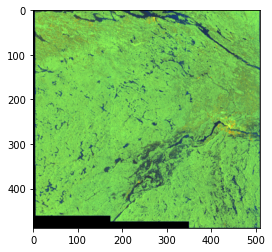

In [34]:
import rasterio
from rasterio.plot import show

path = local_paths[0]
with rasterio.open(path) as source:
    show(source)
